<a href="https://colab.research.google.com/github/ChristopheGraveline064/CDA_mesurement/blob/main/cda_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import os

datapath = '/content/drive/MyDrive/aerostick_data/'

# Load your CSV
df_feature = pd.read_csv(os.path.join(datapath, 'tmp-det__=TireTest_Sat Jul 26 083913 2025.csv'))

#TODO the file may or may not have a header
df_target = pd.read_csv(os.path.join(datapath, 'tmp-sum__=TireTest_Sat Jul 26 083913 2025.csv'), header=None)

#TODO Drop non-feature columns if needed
df_target = df_target.drop(columns=[df_target.columns[1]]) # Drop the first column by index

display(df_feature)
display(df_target)

data = df_feature.values.astype(np.float32)
cda = df_target.values.astype(np.float32)

,i,dist,power,speed,air
0,0.00,124.16,24.19,0.00,15.18
1,12.48,124.16,24.19,0.00,158.68
2,20.80,124.16,24.79,99.86,160.93
3,24.96,133.86,25.05,44.46,175.07
4,29.12,117.37,25.39,57.84,185.19
...,...,...,...,...,...
3112,26588.90,0.00,0.63,0.00,0.00
3113,26588.90,0.00,0.63,0.00,0.00
3114,26588.90,0.00,0.63,0.00,0.00
3115,26588.90,0.00,0.63,0.00,0.00


,0,2,3,4,5,6
0,0,489,641,690,828,0.2588
1,1,915,1061,1112,1246,0.2604
2,2,1320,1470,1524,1657,0.2610
3,3,1790,1936,2005,2143,0.2559
4,4,2213,2361,2425,2552,0.2558
5,5,2624,2769,2824,2962,0.2562


#Data Processing

In [ ]:
import tensorflow as tf
import numpy as np

features = []
targets = []

target_column = -1  # Assuming this is where your target/label is in cda

for i in range(len(cda)):
    # Extract the label
    label = cda[i, target_column]

    # Extract the variable-length sequence (rows from data)
    #TODO the number of column used may change
    seq1 = data[int(cda[i, 0]):int(cda[i, 1]), 2:]  # skip column 0, use all others
    seq2 = data[int(cda[i, 2]):int(cda[i, 3]), 2:]
    sequence = np.concatenate([seq1, seq2], axis=0)

    features.append(sequence)  # variable-length 2D array
    targets.append(label)

    #sequence = data[int(cda[i, 2]):int(cda[i, 3]), 1:]
    #features.append(sequence)  # variable-length 2D array
    #targets.append(label)

# Convert features to a RaggedTensor
ragged_features = tf.ragged.constant(features, dtype=tf.float32)

# Convert targets to a normal tensor
targets = tf.convert_to_tensor(targets, dtype=tf.float32)



In [ ]:
# Pad the ragged features
padded_features = ragged_features.to_tensor(default_value=0.0)

#convert  to numpy
padded_features_np = padded_features.numpy()
targets_np = targets.numpy()

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(padded_features_np, targets_np, test_size=0.2, random_state=42)

#Model

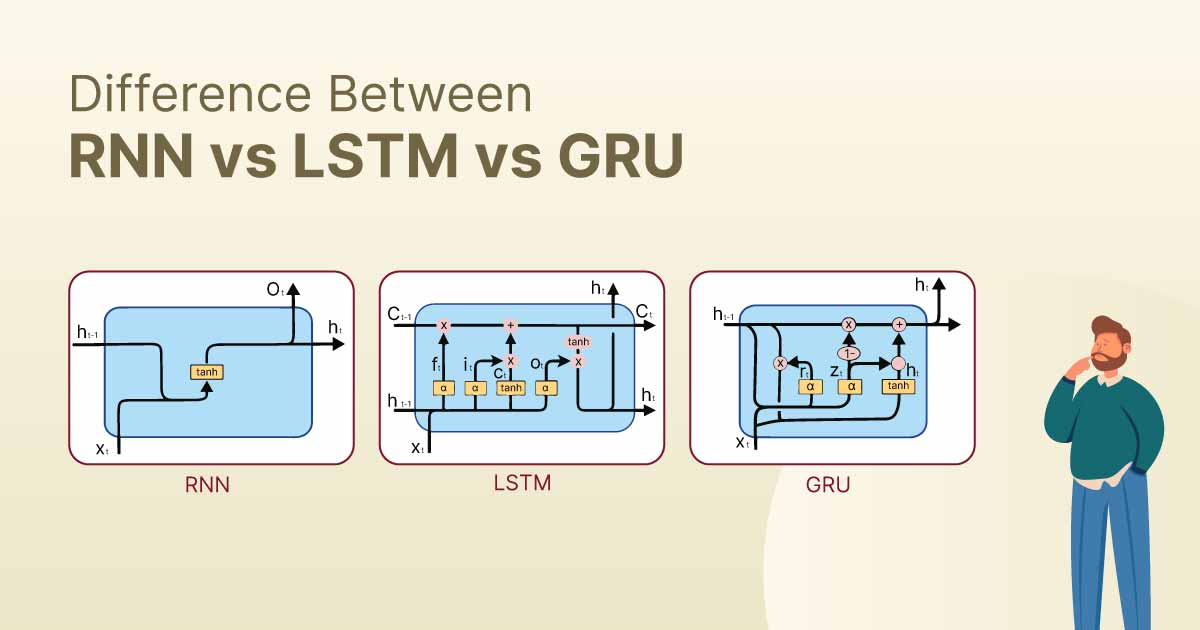

In [ ]:
import tensorflow as tf

model_type = 'GRU'

if model_type == 'RNN':
  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, padded_features_np.shape[2])),
    tf.keras.layers.SimpleRNN(64, return_sequences=True),
    tf.keras.layers.SimpleRNN(64, return_sequences=False),
    tf.keras.layers.Dense(1)
  ])
elif model_type == 'LSTM':
  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, padded_features_np.shape[2])),
    tf.keras.layers.LSTM(64, return_sequences=False),
    tf.keras.layers.Dense(1)
  ])
elif model_type == 'GRU':
  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, padded_features_np.shape[2])),
    #tf.keras.layers.GRU(64, return_sequences=True), # Changed to True
    #tf.keras.layers.GRU(64, return_sequences=True), # Changed to True
    tf.keras.layers.GRU(64, return_sequences=False),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

##Neural Ordinary Differential Equations (arXiv:1806.07366)

#Train

In [ ]:
history = model.fit(X_train, y_train, epochs=75, batch_size=4, validation_data=(X_test, y_test))

Epoch 1/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.2444 - mae: 0.4137 - val_loss: 0.0594 - val_mae: 0.2437
Epoch 2/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.1355 - mae: 0.3326 - val_loss: 0.0518 - val_mae: 0.2276
Epoch 3/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0691 - mae: 0.2572 - val_loss: 0.0446 - val_mae: 0.2112
Epoch 4/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0370 - mae: 0.1891 - val_loss: 0.0378 - val_mae: 0.1944
Epoch 5/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step - loss: 0.0286 - mae: 0.1589 - val_loss: 0.0313 - val_mae: 0.1770
Epoch 6/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step - loss: 0.0333 - mae: 0.1821 - val_loss: 0.0253 - val_mae: 0.1592
Epoch 7/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0406 - mae: 0.1922 - val_loss: 0.0198 - val_mae: 0.1408
Epoch 8/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0440 - mae: 0.1901 - val_loss: 0.0149 - val_mae: 0.1219
Epoch 9/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 875ms/step - loss: 0.0420 - mae: 0.1782 - val_loss:

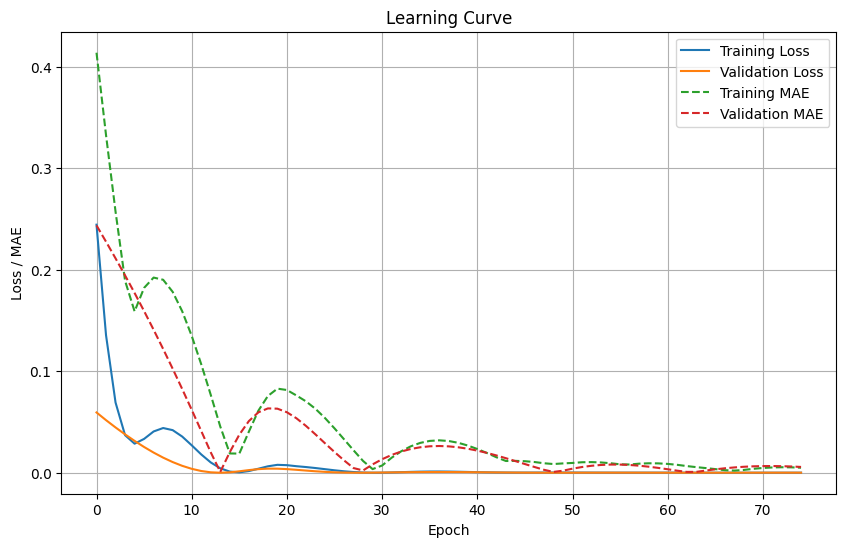

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Optional: plot additional metrics like MAE
if 'mae' in history.history:
    plt.plot(history.history['mae'], label='Training MAE', linestyle='--')
    plt.plot(history.history['val_mae'], label='Validation MAE', linestyle='--')

plt.title('Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss / MAE')
plt.legend()
plt.grid(True)
plt.show()


#Evaluate

In [ ]:
model.evaluate(X_test, y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 3.3170e-05 - mae: 0.0057


[3.31698392983526e-05, 0.00570349395275116]

Sequance A->B or B->A: \\
RNN: [0.04569952189922333, 0.1260969489812851] \\
LSTM: [0.006350232753902674, 0.05139995738863945] \\
GRU: [0.0006004805327393115, 0.016981273889541626] \\

Sequance A->B->A \\
RNN: [0.0014131211210042238, 0.03691475838422775] \\
LSTM: [0.00016026363300625235, 0.01250477135181427] \\
GRU: [7.255527634697501e-06, 0.002303078770637512]

##RNN (epoch: 75, batch size: 4):

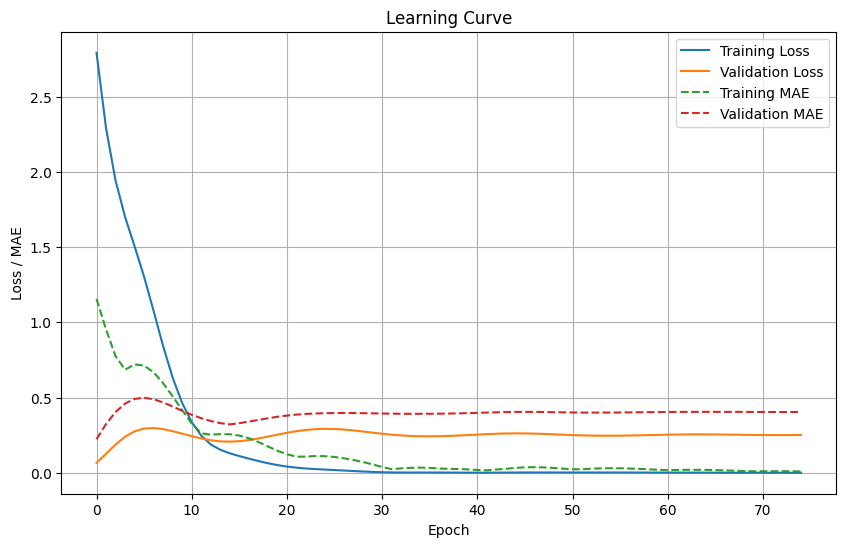

##LSTM (epoch: 75, batch size: 4)

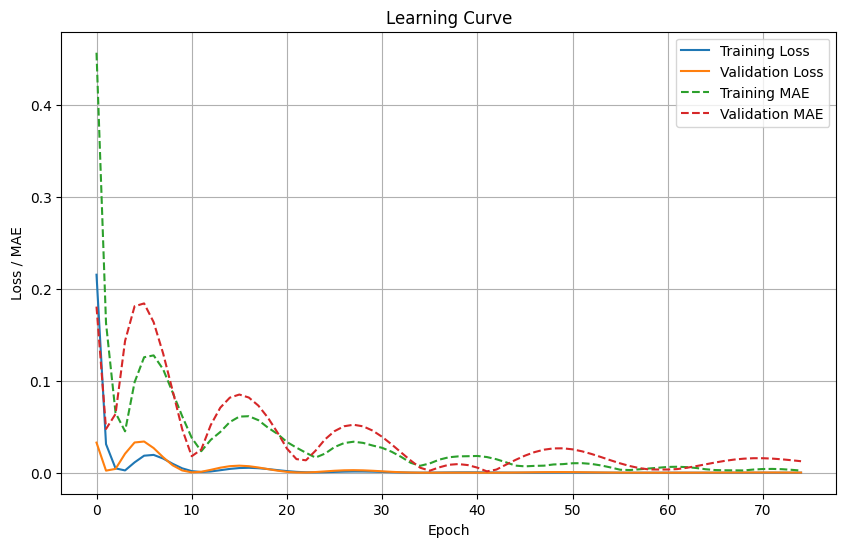

##GRU (ephoch: 75, batch size: 4)

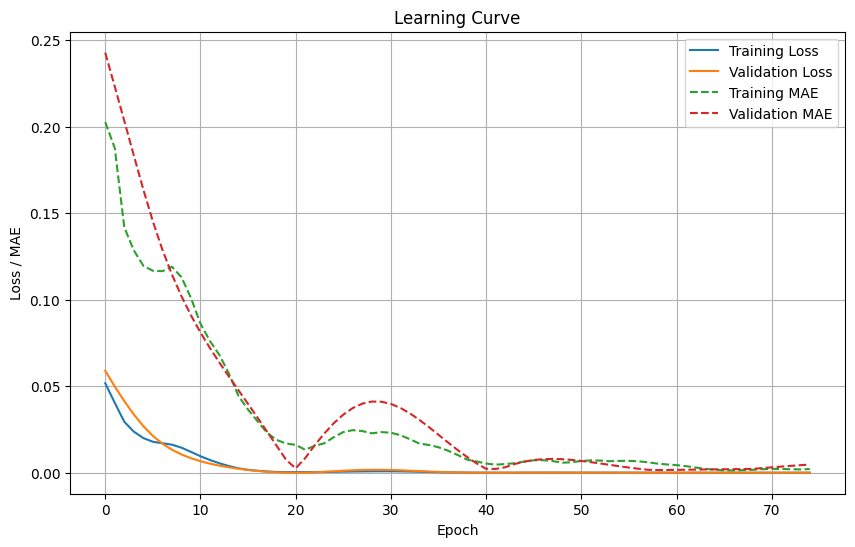